In [ ]:
!pip install torch_geometric

In [ ]:
# Ayurvedic Recommendation System: HeirGCN vs Decision Tree
# --------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
import networkx as nx
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.utils import to_networkx
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [ ]:
# 1. Generate Synthetic Ayurvedic Data with Formatted Output
# ------------------------------------------------------

# Define expanded Ayurvedic diseases
ayurvedic_diseases = [
    # diseases
    "Vata Imbalance", "Pitta Imbalance", "Kapha Imbalance",
    "Amavata (Rheumatoid Arthritis)", "Sandhigata Vata (Osteoarthritis)",
    "Tamaka Shwasa (Bronchial Asthma)", "Pandu (Anemia)",
    "Yakrit Vikara (Liver Disorders)", "Madhumeha (Diabetes)",
    "Hrdroga (Heart Disease)", "Twak Roga (Skin Disorders)",
    "Shwasa (Respiratory Disorders)", "Udara Roga (Abdominal Disorders)",
    "Vatavyadhi (Neurological Disorders)", "Mutrakrichra (Urinary Disorders)",
    "Agnimandya (Digestive Disorders)", "Jvara (Fever)",
    "Atisara (Diarrhea)", "Prameha (Urinary Disorders)",
    "Rakta Vikara (Blood Disorders)",

    # New diseases
    "Vrana (Wound/Ulcer)", "Kushtha (Leprosy/Skin Diseases)",
    "Unmada (Psychosis/Mental Disorders)", "Apasmara (Epilepsy)",
    "Shotha (Edema/Inflammation)", "Kamala (Jaundice)",
    "Grahani (IBS/Malabsorption)", "Gulma (Abdominal Tumors)",
    "Arsha (Hemorrhoids)", "Chardi (Vomiting)",
    "Hikka (Hiccups)", "Swarabheda (Voice Disorders)",
    "Kasa (Cough)", "Rajayakshma (Tuberculosis)",
    "Arbuda (Tumor/Cancer)", "Netraroga (Eye Disorders)",
    "Karnasrava (Ear Discharge)", "Mukharoga (Oral Disorders)",
    "Shiroroga (Headache Disorders)", "Khalitya (Hair Loss)",
    "Shleepada (Filariasis)", "Krichchhra (Dysuria)", "Pratishyaya (Rhinitis)",
    "Nasagata Roga (Nasal Disorders)", "Vishamajwara (Intermittent Fever)",
    "Kasa Roga (Chronic Cough)", "Amlapitta (Hyperacidity)", "Udavarta (Reverse Peristalsis)",
    "Mukhapaka (Stomatitis)", "Vidradhi (Abscess)", "Grahani Dosha", "Yakritshotha (Hepatitis)",
    "Ardita (Facial Paralysis)", "Shlipada", "Vatarakta (Gout)", "Raktapitta (Hemorrhagic Disorders)",
    "Shukrameha (Spermatorrhea)", "Rakta Gulma", "Ajeerna (Indigestion)", "Ajirna",
    "Krumi Roga (Parasitic Infection)", "Stanya Dosha (Lactation Issues)", "Stanyaksaya (Low Breast Milk)",
    "Mukhdooshika (Acne)", "Netravikara", "Tama (Blindness)", "Karna Roga", "Karnanada (Tinnitus)",
    "Nasagata Jwara", "Anidra", "Chhardi Vega", "Vataprakopa", "Pleeha Vikara (Spleen Disorders)",
    "Mandagni", "Sannipata Jwara", "Vishajanya Vyadhi (Poison-related)", "Mrudu Kasa",
    "Switra (Vitiligo)", "Bhagandara (Fistula)", "Kusta Roga (Chronic Skin Disease)",
    "Tiktakshaya", "Meda Roga (Obesity)", "Udakavaha Srotodushti", "Shotha Jvara",
    "Granthi (Benign Tumor)", "Udakakshaya (Dehydration)", "Stambha (Rigidity)",
    "Akshiroga (Visual Weakness)", "Jihwa Roga (Tongue Disorders)", "Chakshushya Vikriti",
    "Asya Roga", "Pakshaghata (Hemiplegia)", "Sarpavisha (Snake Poison)", "Madatyaya (Alcoholism)",
    "Garavisha (Chronic Toxins)", "Udakavaha Vyadhi", "Vishaghata", "Ajirna Jwara",
    "Swedana Dosha", "Rakta Dushti", "Sukra Dushti", "Stree Roga (Gynecological Disorders)",
    "Pushpaghni Jwara", "Pittaja Shotha", "Manasika Vikara", "Udvega (Stress)",
    "Smaranadosha (Memory Impairment)", "Vajikarana Vyadhi (Impotence)", "Balakshaya",
    "Rasavaha Srotas Dusti", "Mootragraha", "Hrudshoola (Angina)", "Vishada (Depression)",
    "Nidranasha", "Jihvaroga", "Antrakujana (Borborygmus)", "Kukundara Shoola (Tailbone Pain)",
    "Vataja Pandu", "Vishmashana", "Snayugata Vata", "Shuklaghata", "Netra Daha",
    "Mutraghata (Urinary Retention)", "Majjagata Roga", "Yoni Vyapad (Uterine Disorders)",
    "Shukra Vriddhi", "Netrashotha", "Prachanda Jwara", "Kukshi Shoola", "Hridaya Roga",
    "Garbhashaya Vikara", "Udaramaya", "Atimala", "Stanyavikara", "Mootra Roga",
    "Siragata Vata", "Jalodara", "Ashmari (Kidney Stones)", "Vataja Jwara", "Paittika Jwara",
    "Kapha Jwara", "Kapha-Vata Vyadhi", "Nadivrana (Sinus/Fistula)", "Sirasula",
    "Hridayakshobha", "Kaphadhika Vyadhi", "Agnisada", "Tandra (Lethargy)",
    "Kukkutanda Shotha", "Madhumeha Pidaka (Diabetic Ulcers)",
]

# Define expanded Ayurvedic symptoms
ayurvedic_symptoms = [
    # symptoms
    "Dry skin", "Weight loss", "Constipation", "Anxiety", "Insomnia",
    "Inflammation", "Acid reflux", "Anger issues", "Burning sensation",
    "Excess sweating", "Weight gain", "Cold sensation", "Lethargy",
    "Excessive sleep", "Joint pain", "Stiffness", "Swelling",
    "Breathlessness", "Wheezing", "Cough", "Pale complexion", "Fatigue",
    "Yellowish discoloration", "Nausea", "Excessive thirst", "Frequent urination",
    "Chest pain", "Palpitations", "Rash", "Itching", "Redness", "Bleeding",
    "Abdominal pain", "Bloating", "Numbness", "Paralysis", "Tremors", "Burning urination",
    "Poor digestion", "Loss of appetite", "High fever", "Low fever", "Loose motions",
    "Excessive urination", "Dark urine", "Blood in urine", "Easy bruising",

    # New symptoms
    "Cracking joints", "Brittle nails", "Hair fall", "Premature graying",
    "Dizziness", "Blurred vision", "Tinnitus (ringing in ears)", "Memory loss",
    "Confusion", "Excessive talking", "Reduced taste sensation", "Mouth ulcers",
    "Gum bleeding", "Bad breath", "Excessive salivation", "Dry mouth",
    "Hoarseness of voice", "Throat pain", "Difficulty swallowing", "Irregular heartbeat",
    "Cold extremities", "Hot flashes", "Night sweats", "Muscle cramps",
    "Muscle weakness", "Indigestion", "Gastric burning", "Excessive gas",
    "Mucus in stool", "Undigested food in stool", "Disturbed sleep", "Nightmares",
    "Excessive thirst during night","Sneezing", "Runny nose", "Sinus pressure", "Post-nasal drip", "Dry cough",
    "Wet cough", "Loss of smell", "Loss of taste", "Throat dryness", "Neck stiffness",
    "Limb heaviness", "Cold sweat", "Drowsiness", "Head spinning", "Itchy scalp",
    "Oily skin", "Burning feet", "Leg swelling", "Dry eyes", "Tearing eyes",
    "Light sensitivity", "Ear pain", "Ear fullness", "Ear ringing", "Frequent headaches",
    "Facial pain", "Facial twitching", "Tooth pain", "Jaw pain", "Neck pain",
    "Tongue discoloration", "Dry lips", "Excess salivation", "Cracks in lips",
    "Stomach cramps", "Gas retention", "Chest tightness", "Chills", "Loss of voice",
    "Mouth burning", "Scalp sensitivity", "Greasy hair", "Nail discoloration",
    "Night blindness", "Craving sweet", "Craving sour", "Craving salty", "Muscle fatigue",
    "Delayed reflexes", "Eye twitching", "Weak grip", "Cold hands", "Tingling sensation",
    "Sweaty palms", "Nail biting", "Fainting", "Irregular menses", "Painful urination",
    "Smelly sweat", "Hair thinning", "Red tongue", "Coated tongue", "Teeth grinding",
    "Irritable mood", "Compulsive thoughts", "Giddiness", "Trembling hands",
    "Sudden fear", "Dry palms", "Lack of coordination", "Dry stools", "Hard stools",
    "Nocturia", "Scanty urine", "Strong body odor", "Weak digestion", "Dry throat",
    "Sun sensitivity", "Dry nostrils", "Low libido", "Hyperactivity",
]

# Define expanded Ayurvedic treatments
ayurvedic_treatments = [
    # treatments
    "Warm oil massage", "Vata pacifying diet", "Ashwagandha", "Triphala",
    "Cooling herbs", "Pitta pacifying diet", "Amalaki", "Guduchi",
    "Warming herbs", "Kapha pacifying diet", "Trikatu", "Guggulu",
    "Panchakarma therapy", "Vamana (therapeutic emesis)", "Virechana (purgation therapy)",
    "Basti (medicated enema)", "Nasya (nasal administration)", "Raktamokshana (bloodletting)",
    "Abhyanga (oil massage)", "Shirodhara (oil dripping)", "Swedana (steam therapy)",
    "Pinda Sweda (bolus fomentation)", "Lepa (herbal paste application)",
    "Rasayana therapy", "Chyawanprash", "Brahmi", "Shankhapushpi",
    "Shatavari", "Kumari (Aloe Vera)", "Haritaki", "Punarnava",
    "Kutki", "Neem", "Turmeric", "Ginger", "Cumin", "Coriander",
    "Fenugreek", "Licorice", "Holy Basil (Tulsi)", "Amla",
    "Yoga therapy", "Pranayama", "Meditation", "Dietary restrictions",
    "Fasting therapy", "Specialized Ayurvedic formulations",

    # New treatments
    "Kati Basti (oil pooling therapy)", "Netra Tarpana (eye rejuvenation)",
    "Takradhara (buttermilk therapy)", "Pizhichil (oil bath therapy)",
    "Udvartana (powder massage)", "Jambeera Pinda Sweda (lemon bundle massage)",
    "Navara Kizhi (rice bundle massage)", "Ela Kizhi (leaf bundle therapy)",
    "Navarakizhi (rice bolus massage)", "Tailadhara (oil pouring therapy)",
    "Agnikarma (heat therapy)", "Jalaukavacharana (leech therapy)",
    "Marma therapy", "Karna Purana (ear oil therapy)", "Mukha Lepa (face pack)",
    "Bhasti (bladder cleansing)", "Dhumapana (medicinal smoking)",
    "Gandusha (oil pulling)", "Anjana (eye treatment)", "Kshara therapy",
    "Agastya Haritaki", "Sitopaladi churna", "Avipattikar churna",
    "Chandraprabha vati", "Arogyavardhini vati", "Lashunadi vati",
    "Hingvashtak churna", "Mahanarayana oil", "Ksheerabala oil",
    "Sound therapy", "Chromotherapy (color therapy)", "Acupressure",
    "Seasonal purification","Shiro Abhyanga (head massage)", "Padabhyanga (foot massage)", "Nabhi Basti",
    "Hrid Basti", "Shiro Vasti", "Janu Basti", "Uro Basti", "Kavala Graha",
    "Avagaha Snana (herbal bath)", "Takra Vasti", "Ksheera Vasti", "Pichu Therapy",
    "Anuvasana Basti", "Matra Basti", "Seka", "Herbal fumigation", "Triphala kwatha",
    "Dashamoola kwatha", "Kanchnar guggulu", "Haridra khanda", "Manjishtha", "Gokshura",
    "Bala oil", "Rasnadi churna", "Aswagandharishta", "Brahmi vati", "Drakshasava",
    "Khadirarishta", "Arjunarishta", "Dashmoolarishta", "Kumaryasava", "Medhya Rasayana",
    "Mahasudarshan churna", "Triphala guggulu", "Punarnavadi mandoor", "Lodhrasava",
    "Shatavarigulam", "Swarna Bhasma", "Abhrak Bhasma", "Muktapishti", "Kaharuba Pishti",
    "Kamdudha Ras", "Sutshekhar Ras", "Herbal kashayam", "Arogya vati", "Ayush Kwath",
    "Amla Ras", "Neem oil application", "Amla juice fasting", "Honey and turmeric mix",
    "Ginger water therapy", "Cow ghee application", "Sesame oil pulling", "Castor oil purgation",
    "Herbal eye drops", "Rasayana Avaleha", "Sitopaladi honey mix", "Sankhapushpi syrup",
    "Ayurvedic nasal oil", "Ayurvedic tooth powder", "Tridosha balancing tea",
    "Lepa with turmeric and sandal", "Mantras and dhyana", "Mud therapy", "Crystal therapy",
    "Bija mantra healing", "Panchabhoota harmonizing", "Marmani stimulation", "Ayurvedic detox patches",
    "Dosha-specific tea blends", "Taila Dhoopana", "Herbal lozenges", "Herbal infusions",
    "Seasonal Virechana", "Herbal bath soaks", "Traditional dietary regimen",
    "Organic ghee therapy", "Moon milk therapy", "Mantra chanting", "Mudra therapy",
    "Ayurvedic smoothies", "Spiced buttermilk", "Balya therapy", "Ayurvedic sleep tonics"
]

severity_levels = ["Mild", "Moderate", "Severe"]

# Function to assign symptoms to diseases with different probabilities
def create_disease_symptom_mapping():
    disease_symptom_map = {}
    for disease in ayurvedic_diseases:
        # Each disease can have 3-8 symptoms
        num_symptoms = random.randint(3, 8)
        # Assign symptoms with probabilities
        symptoms = random.sample(ayurvedic_symptoms, num_symptoms)
        # Create mapping with probabilities
        symptom_probs = {}
        for symptom in symptoms:
            # Probability of this symptom occurring with this disease (50-95%)
            symptom_probs[symptom] = random.uniform(0.5, 0.95)
        disease_symptom_map[disease] = symptom_probs
    return disease_symptom_map

# Create disease-treatment mapping
def create_disease_treatment_mapping():
    treatment_map = {}
    for disease in ayurvedic_diseases:
        # Each disease can be treated with 2-5 treatments
        num_treatments = random.randint(2, 5)
        treatments = random.sample(ayurvedic_treatments, num_treatments)
        treatment_map[disease] = treatments
    return treatment_map

# Create the mappings
disease_symptom_map = create_disease_symptom_mapping()
disease_treatment_map = create_disease_treatment_mapping()

# Generate synthetic data
def generate_synthetic_data(n_samples=10000):
    data = []

    for _ in range(n_samples):
        # Randomly select a disease
        disease = random.choice(ayurvedic_diseases)

        # Get the symptom probabilities for this disease
        symptom_probs = disease_symptom_map[disease]

        # Select symptoms based on probabilities
        selected_symptoms = []
        for symptom, prob in symptom_probs.items():
            if random.random() < prob:
                selected_symptoms.append(symptom)

        # Ensure at least one symptom is selected
        if not selected_symptoms:
            selected_symptoms = [random.choice(list(symptom_probs.keys()))]

        # Join symptoms with commas for the dataset
        symptoms_str = ", ".join(selected_symptoms)

        # Select severity
        severity = random.choice(severity_levels)

        # Get treatments for this disease
        treatments = disease_treatment_map[disease]
        treatment_str = ", ".join(treatments)

        data.append({
            'disease': disease,
            'symptoms': symptoms_str,
            'severity': severity,
            'treatment': treatment_str
        })

    return pd.DataFrame(data)

# Set random seed for reproducibility
random.seed(42)

# Generate synthetic data
df = generate_synthetic_data(10000)

# Save the data to CSV
df.to_csv('ayurvedic_dataset.csv', index=False)

# ------ DISPLAY OUTPUT WITH PROPER FORMATTING ------

print("\n" + "="*80)
print(" "*30 + "AYURVEDIC DATASET ANALYSIS")
print("="*80 + "\n")

# 1. Display sample data in a formatted table
print("\033[1m" + "SAMPLE DATA (First 5 Rows):" + "\033[0m")
print(tabulate(df.head(), headers='keys', tablefmt='pretty', showindex=False))
print("\n")

# 2. Basic Dataset Statistics
print("\033[1m" + "DATASET STATISTICS:" + "\033[0m")
stats_data = [
    ["Number of samples", len(df)],
    ["Number of unique diseases", df['disease'].nunique()],
    ["Number of unique symptoms combinations", df['symptoms'].nunique()],
    ["Number of unique treatments combinations", df['treatment'].nunique()]
]
print(tabulate(stats_data, headers=['Statistic', 'Value'], tablefmt='pretty'))
print("\n")

# 3. Severity Distribution
print("\033[1m" + "SEVERITY DISTRIBUTION:" + "\033[0m")
severity_counts = df['severity'].value_counts().reset_index()
severity_counts.columns = ['Severity Level', 'Count']
severity_counts['Percentage'] = (severity_counts['Count'] / len(df) * 100).round(2)
print(tabulate(severity_counts, headers='keys', tablefmt='pretty', showindex=False))
print("\n")

# 4. Top Diseases
print("\033[1m" + "TOP 10 MOST COMMON DISEASES:" + "\033[0m")
disease_counts = df['disease'].value_counts().head(10).reset_index()
disease_counts.columns = ['Disease', 'Count']
disease_counts['Percentage'] = (disease_counts['Count'] / len(df) * 100).round(2)
print(tabulate(disease_counts, headers='keys', tablefmt='pretty', showindex=False))
print("\n")

# 5. Most Common Symptoms (requires parsing)
print("\033[1m" + "TOP 10 MOST COMMON SYMPTOMS:" + "\033[0m")
all_symptoms = []
for symptom_list in df['symptoms'].str.split(', '):
    all_symptoms.extend(symptom_list)

symptom_counts = pd.Series(all_symptoms).value_counts().head(10).reset_index()
symptom_counts.columns = ['Symptom', 'Count']
symptom_counts['Percentage'] = (symptom_counts['Count'] / len(all_symptoms) * 100).round(2)
print(tabulate(symptom_counts, headers='keys', tablefmt='pretty', showindex=False))
print("\n")

# 6. Most Common Treatments (requires parsing)
print("\033[1m" + "TOP 10 MOST COMMON TREATMENTS:" + "\033[0m")
all_treatments = []
for treatment_list in df['treatment'].str.split(', '):
    all_treatments.extend(treatment_list)

treatment_counts = pd.Series(all_treatments).value_counts().head(10).reset_index()
treatment_counts.columns = ['Treatment', 'Count']
treatment_counts['Percentage'] = (treatment_counts['Count'] / len(all_treatments) * 100).round(2)
print(tabulate(treatment_counts, headers='keys', tablefmt='pretty', showindex=False))
print("\n")

# 7. Distribution of Symptoms per Disease
print("\033[1m" + "DISTRIBUTION OF SYMPTOMS PER DISEASE:" + "\033[0m")
symptom_counts_per_disease = df['symptoms'].apply(lambda x: len(x.split(', ')))
symptom_distribution = symptom_counts_per_disease.value_counts().sort_index().reset_index()
symptom_distribution.columns = ['Number of Symptoms', 'Count of Diseases']
symptom_distribution['Percentage'] = (symptom_distribution['Count of Diseases'] / len(df) * 100).round(2)
print(tabulate(symptom_distribution, headers='keys', tablefmt='pretty', showindex=False))
print("\n")

# 8. Visualization - Disease Severity Relationship
print("\033[1m" + "VISUALIZATION DATA - DISEASE SEVERITY RELATIONSHIP:" + "\033[0m")
# Get top 5 diseases for visualization
top_diseases = df['disease'].value_counts().head(5).index.tolist()
severity_pivot = pd.crosstab(df[df['disease'].isin(top_diseases)]['disease'],
                             df[df['disease'].isin(top_diseases)]['severity'])

# Calculate percentages for better comparison
severity_pivot_pct = severity_pivot.div(severity_pivot.sum(axis=1), axis=0) * 100
severity_data = severity_pivot_pct.reset_index().melt(id_vars=['disease'],
                                                     value_vars=['Mild', 'Moderate', 'Severe'],
                                                     var_name='Severity', value_name='Percentage')

print(tabulate(severity_pivot.reset_index(), headers='keys', tablefmt='pretty', showindex=False))
print("\n")

print("="*80)
print(" "*30 + "END OF REPORT")
print("="*80)


                              AYURVEDIC DATASET ANALYSIS

SAMPLE DATA (First 5 Rows):
+-------------------------------------+-----------------------------------------------------------------------------+----------+-------------------------------------------------------------------------------------------+
|               disease               |                                  symptoms                                   | severity |                                         treatment                                         |
+-------------------------------------+-----------------------------------------------------------------------------+----------+-------------------------------------------------------------------------------------------+
|         Arsha (Hemorrhoids)         | Tinnitus (ringing in ears), Hoarseness of voice, Chest pain, Irritable mood |  Severe  |                Spiced buttermilk, Amalaki, Herbal infusions, Kamdudha Ras                 |
| Unmada (Psychosis/Mental Di


Bipartite Graph Information:
Number of disease nodes: 150
Number of symptom nodes: 159
Total number of edges: 839


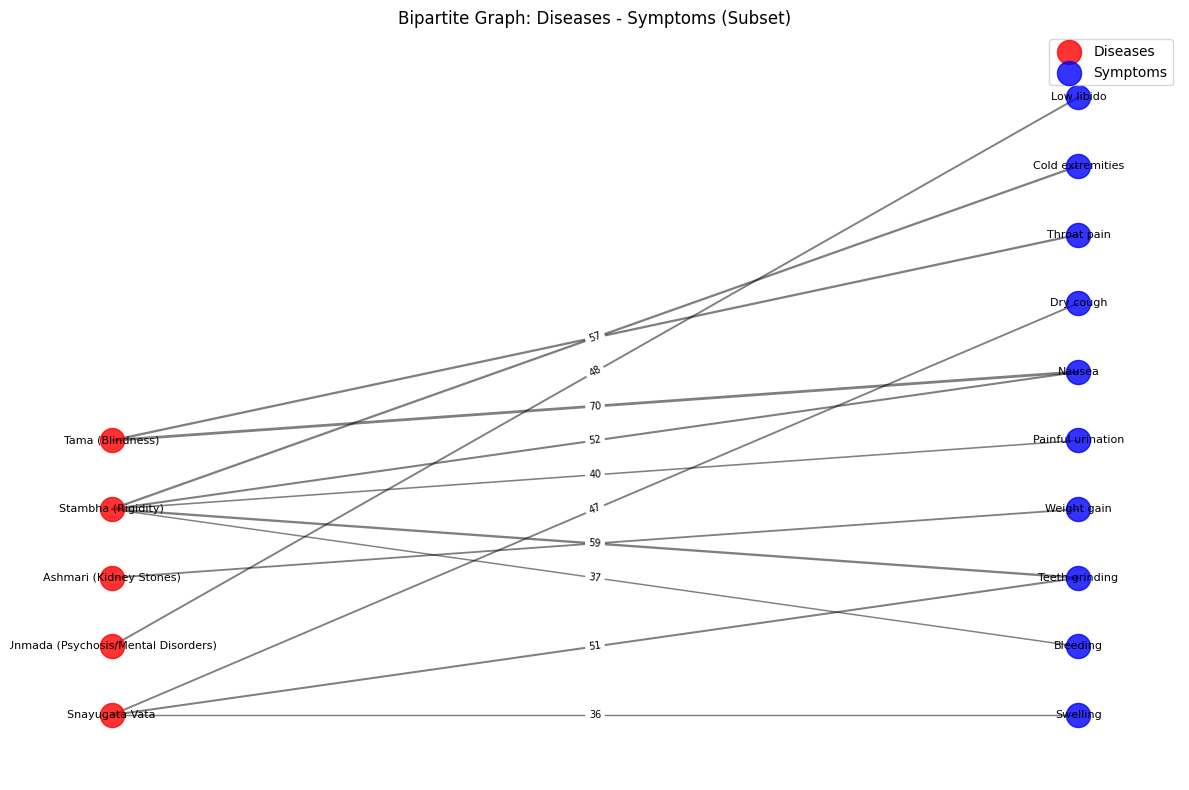

In [ ]:
# 2. Construct and Visualize Bipartite Graph
# ------------------------------------------

def create_bipartite_graph_data(df):
    # Create a graph
    G = nx.Graph()

    # Add nodes for diseases and symptoms
    disease_nodes = set(df['disease'].unique())

    # Extract unique symptoms from the comma-separated strings
    all_symptoms = set()
    for symptoms_str in df['symptoms'].unique():
        symptoms = symptoms_str.split(', ')
        all_symptoms.update(symptoms)

    # Add nodes to the graph
    for disease in disease_nodes:
        G.add_node(disease, bipartite=0, node_type='disease')

    for symptom in all_symptoms:
        G.add_node(symptom, bipartite=1, node_type='symptom')

    # Create edges with weights based on co-occurrence
    edge_weights = {}

    for _, row in df.iterrows():
        disease = row['disease']
        symptoms = row['symptoms'].split(', ')

        for symptom in symptoms:
            if (disease, symptom) not in edge_weights:
                edge_weights[(disease, symptom)] = 0
            edge_weights[(disease, symptom)] += 1

    # Add weighted edges to the graph
    for (disease, symptom), weight in edge_weights.items():
        G.add_edge(disease, symptom, weight=weight)

    return G, disease_nodes, all_symptoms

# Generate synthetic data before creating the graph
df = generate_synthetic_data(10000) # Call the function to create the DataFrame

# Create the bipartite graph
G, disease_nodes, symptom_nodes = create_bipartite_graph_data(df)

# Display information about the bipartite graph
print("\nBipartite Graph Information:")
print(f"Number of disease nodes: {len(disease_nodes)}")
print(f"Number of symptom nodes: {len(symptom_nodes)}")
print(f"Total number of edges: {G.number_of_edges()}")

# Visualize a smaller portion of the graph for clarity
def visualize_bipartite_graph(G, max_nodes=10):
    # Take a subset of the graph for visualization
    sample_diseases = list(disease_nodes)[:5]
    connected_symptoms = set()

    for disease in sample_diseases:
        for neighbor in G.neighbors(disease):
            connected_symptoms.add(neighbor)

    sample_symptoms = list(connected_symptoms)[:max_nodes]

    subgraph_nodes = sample_diseases + sample_symptoms
    subgraph = G.subgraph(subgraph_nodes)

    # Create position layout for bipartite graph
    pos = {}
    pos.update((node, (1, i)) for i, node in enumerate(sample_diseases))
    pos.update((node, (2, i)) for i, node in enumerate(sample_symptoms))

    plt.figure(figsize=(12, 8))

    # Draw nodes
    disease_nodes_sub = [n for n in subgraph.nodes() if subgraph.nodes[n]['bipartite'] == 0]
    symptom_nodes_sub = [n for n in subgraph.nodes() if subgraph.nodes[n]['bipartite'] == 1]

    nx.draw_networkx_nodes(subgraph, pos, nodelist=disease_nodes_sub, node_color='red', node_size=300, alpha=0.8, label='Diseases')
    nx.draw_networkx_nodes(subgraph, pos, nodelist=symptom_nodes_sub, node_color='blue', node_size=300, alpha=0.8, label='Symptoms')

    # Get edge weights for the subgraph
    edge_weights = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]

    # Normalize weights for visualization
    max_weight = max(edge_weights)
    normalized_weights = [2 * w / max_weight for w in edge_weights]

    # Draw edges with weights
    nx.draw_networkx_edges(subgraph, pos, width=normalized_weights, alpha=0.5)

    # Draw labels
    nx.draw_networkx_labels(subgraph, pos, font_size=8)

    # Draw edge labels (weights)
    edge_labels = {(u, v): f"{d['weight']}" for u, v, d in subgraph.edges(data=True)}
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=7)

    plt.title("Bipartite Graph: Diseases - Symptoms (Subset)")
    plt.legend(loc='upper right')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize the bipartite graph
visualize_bipartite_graph(G)

In [ ]:
# 3. Data Preprocessing for Model Training
# ---------------------------------------

# Process data for both models
def preprocess_data(df):
    # Create feature matrix: One-hot encoding of symptoms
    all_symptoms = set()
    for symptoms_str in df['symptoms']:
        symptoms = symptoms_str.split(', ')
        all_symptoms.update(symptoms)
    all_symptoms = sorted(list(all_symptoms))

    # Create symptom features
    X = np.zeros((len(df), len(all_symptoms)))
    for i, symptoms_str in enumerate(df['symptoms']):
        symptoms = symptoms_str.split(', ')
        for symptom in symptoms:
            j = all_symptoms.index(symptom)
            X[i, j] = 1

    # Add severity as a feature
    le_severity = LabelEncoder()
    severity_encoded = le_severity.fit_transform(df['severity'])
    severity_onehot = np.eye(len(severity_levels))[severity_encoded]

    # Combine symptoms and severity features
    X_combined = np.hstack((X, severity_onehot))

    # Encode target (disease)
    le_disease = LabelEncoder()
    y = le_disease.fit_transform(df['disease'])

    return X_combined, y, le_disease, all_symptoms

# Preprocessing for graph model
def create_graph_data(X, y, all_symptoms):
    # Create a mapping of feature indices to node indices
    num_features = X.shape[1]

    # Create edge index tensor for bipartite graph
    # Each sample (patient) is connected to its active features (symptoms)
    edge_index_list = []
    edge_weights_list = []

    for i in range(len(X)):
        for j in range(num_features):
            if X[i, j] > 0:
                # Add edge between sample i and feature j
                edge_index_list.append([i, j + len(X)])  # Offset feature indices
                edge_weights_list.append(X[i, j])  # Use feature value as weight

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_weights = torch.tensor(edge_weights_list, dtype=torch.float)

    # Create node feature tensor
    # Sample features: one-hot encoding of samples
    sample_features = torch.eye(len(X))

    # Feature features: use identity matrix
    feature_features = torch.eye(num_features)

    # Create PyTorch Geometric data object
    # Add a batch index for each sample
    data_list = []
    for i in range(len(X)):
        # Extract the features for the current sample
        sample_features = torch.tensor(X[i], dtype=torch.float).unsqueeze(0)
        # Create a single-node graph for the current sample
        edge_index = torch.tensor([[0, 0]], dtype=torch.long).t().contiguous()

        # Create data object for the current sample
        data = Data(x=sample_features, edge_index=edge_index, y=torch.tensor([y[i]], dtype=torch.long))
        data_list.append(data)

    # Use Batch.from_data_list to create a batched graph
    data = Batch.from_data_list(data_list)

    return data

# Preprocess the data
X, y, le_disease, all_symptoms = preprocess_data(df)

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create graph data for GCN
graph_data = create_graph_data(X, y, all_symptoms)

# Split the data for graph model
train_mask = torch.zeros(graph_data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(graph_data.num_nodes, dtype=torch.bool)

# Set masks for the sample nodes only (not feature nodes)
train_indices, test_indices = train_test_split(range(len(y)), test_size=0.2, random_state=42)
train_mask[train_indices] = True
test_mask[test_indices] = True

graph_data.train_mask = train_mask
graph_data.test_mask = test_mask

print("\nPreprocessed Data Shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Graph data: {graph_data}")


Preprocessed Data Shapes:
X_train shape: (8000, 162)
X_test shape: (2000, 162)
y_train shape: (8000,)
y_test shape: (2000,)
Graph data: DataBatch(x=[10000, 162], edge_index=[2, 10000], y=[10000], batch=[10000], ptr=[10001], train_mask=[10000], test_mask=[10000])


In [ ]:
# 4. Model 1: Decision Tree Classifier
# -----------------------------------

# Train the decision tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
dt_preds = dt_model.predict(X_test)

# Calculate metrics
dt_accuracy = accuracy_score(y_test, dt_preds)
dt_f1 = f1_score(y_test, dt_preds, average='weighted')
dt_precision = precision_score(y_test, dt_preds, average='weighted')
dt_recall = recall_score(y_test, dt_preds, average='weighted')

print("\nDecision Tree Model Performance:")
print(f"Accuracy: {dt_accuracy:.4f}")
print(f"F1 Score: {dt_f1:.4f}")
print(f"Precision: {dt_precision:.4f}")
print(f"Recall: {dt_recall:.4f}")


Decision Tree Model Performance:
Accuracy: 0.9310
F1 Score: 0.9318
Precision: 0.9394
Recall: 0.9310


In [ ]:
# 5. Model 2: Hierarchical Graph Convolutional Network with Top-K Pooling
# ----------------------------------------------------------------------

class HeirGCN(nn.Module):
    def __init__(self, num_features, num_classes):
        super(HeirGCN, self).__init__()

        # GCN layers
        self.conv1 = GCNConv(num_features, 128)
        self.pool1 = TopKPooling(128, ratio=0.8)
        self.conv2 = GCNConv(128, 64)
        self.pool2 = TopKPooling(64, ratio=0.8)

        # Hierarchical feature extraction
        self.conv3 = GCNConv(64, 32)

        # Output layer
        self.fc = nn.Linear(32, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # If batch is None (single graph), create a batch vector
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long)

        # First GCN layer and pooling
        x = F.relu(self.conv1(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)

        # Second GCN layer and pooling
        x = F.relu(self.conv2(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)

        # Third GCN layer (hierarchical feature extraction)
        x = F.relu(self.conv3(x, edge_index))

        # Global pooling (mean of node features)
        x = global_mean_pool(x, batch)

        # Fully connected layer
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

# Train the HeirGCN model
def train_graph_model(data, model, optimizer, epochs=100):
    model.train()

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(data)

        # Only use the sample nodes for loss calculation
        loss = F.nll_loss(output[data.train_mask], data.y[data.train_mask])

        loss.backward()
        optimizer.step()

        if (epoch+1) % 20 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    return model

# Evaluate the HeirGCN model
def test_graph_model(data, model):
    model.eval()

    with torch.no_grad():
        logits = model(data)
        pred = logits.max(1)[1]

        # Only evaluate on test sample nodes
        correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
        total = data.test_mask.sum().item()

        accuracy = correct / total

        # Calculate additional metrics
        y_true = data.y[data.test_mask].cpu().numpy()
        y_pred = pred[data.test_mask].cpu().numpy()

        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')

    return accuracy, f1, precision, recall, y_pred

# Initialize and train the HeirGCN model
gcn_model = HeirGCN(graph_data.num_features, len(ayurvedic_diseases))
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)

print("\nTraining HeirGCN Model:")
gcn_model = train_graph_model(graph_data, gcn_model, optimizer, epochs=100)

# Evaluate the HeirGCN model
gcn_accuracy, gcn_f1, gcn_precision, gcn_recall, gcn_preds = test_graph_model(graph_data, gcn_model)

print("\nHeirGCN Model Performance:")
print(f"Accuracy: {gcn_accuracy:.4f}")
print(f"F1 Score: {gcn_f1:.4f}")
print(f"Precision: {gcn_precision:.4f}")
print(f"Recall: {gcn_recall:.4f}")


Training HeirGCN Model:
Epoch 20/100, Loss: 3.9652
Epoch 40/100, Loss: 0.9014
Epoch 60/100, Loss: 0.1220
Epoch 80/100, Loss: 0.0581
Epoch 100/100, Loss: 0.0515

HeirGCN Model Performance:
Accuracy: 0.9500
F1 Score: 0.9497
Precision: 0.9552
Recall: 0.9500



Model Comparison:
      Metric  Decision Tree   HeirGCN
0   Accuracy       0.931000  0.950000
1   F1 Score       0.931767  0.949738
2  Precision       0.939446  0.955169
3     Recall       0.931000  0.950000


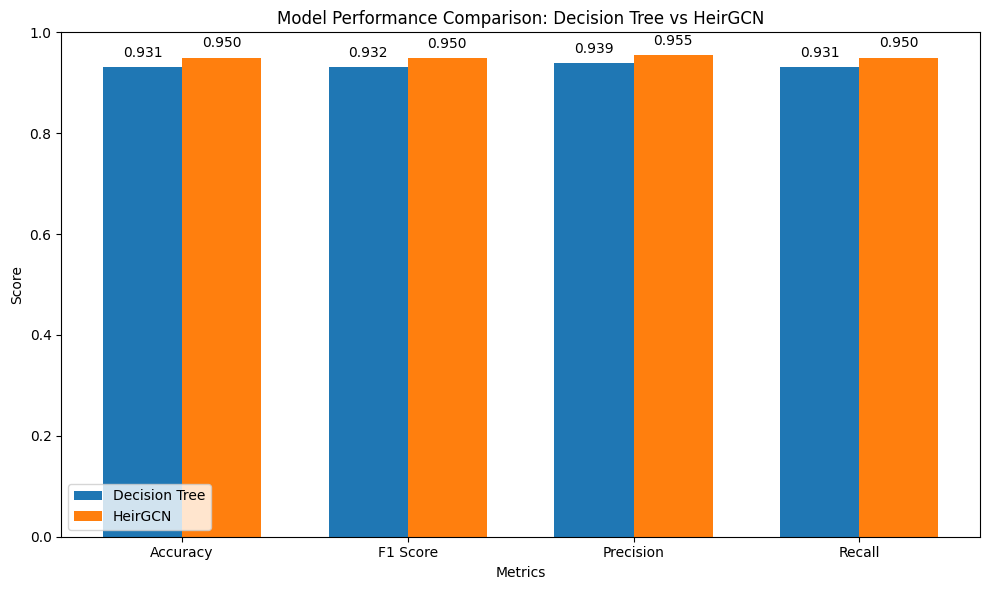

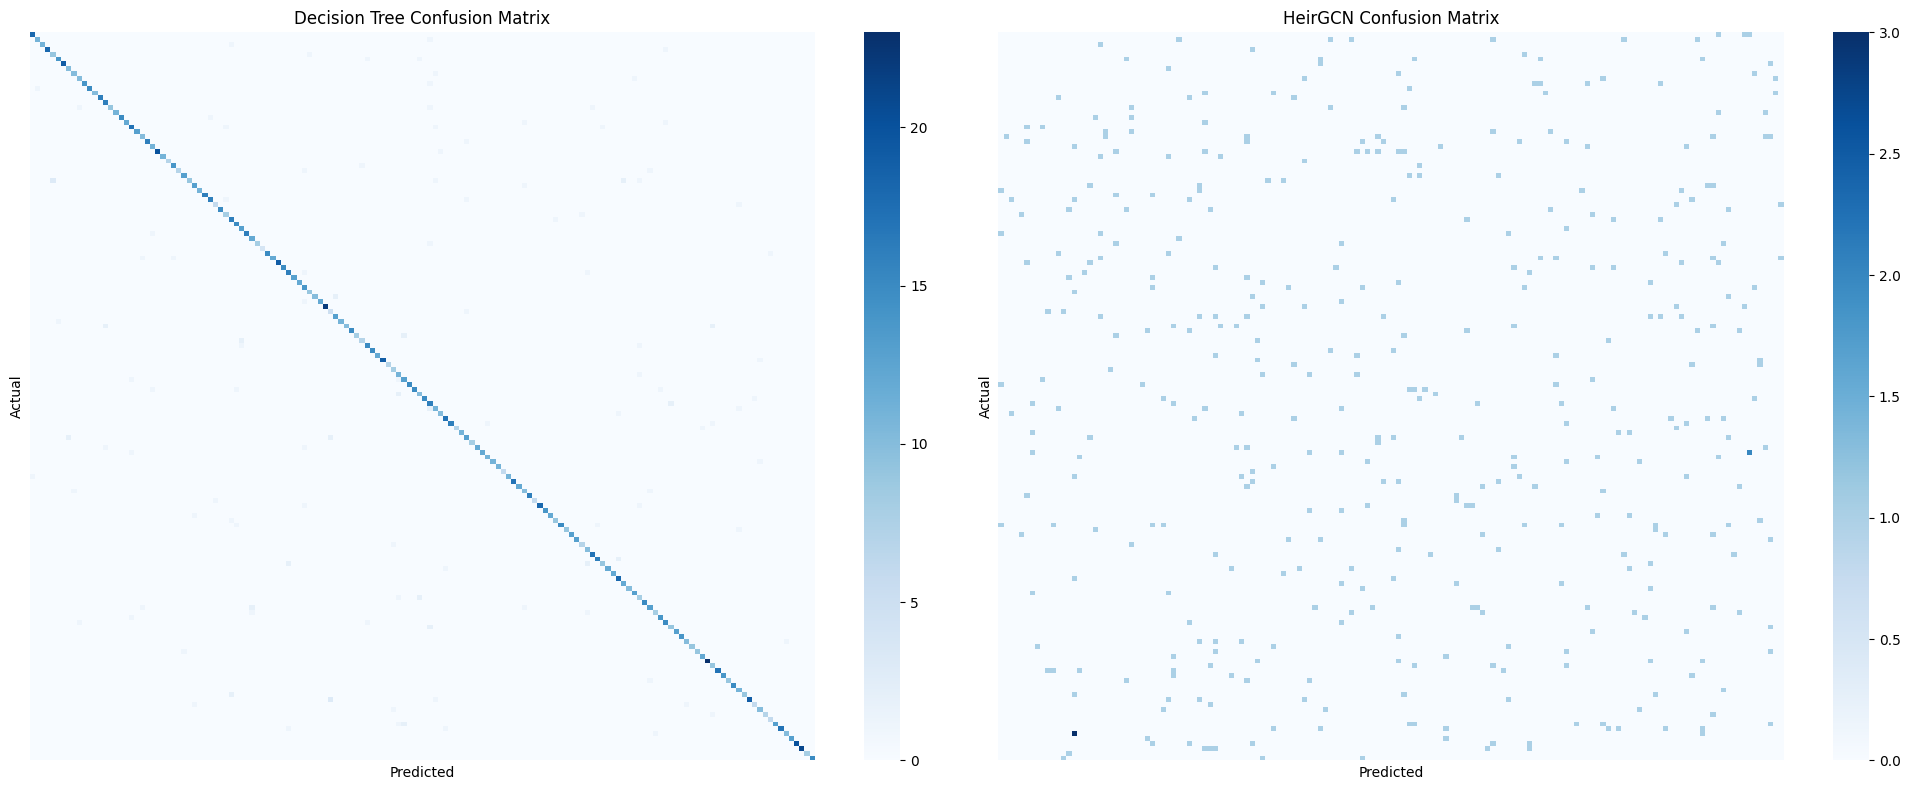

In [ ]:
# 6. Model Comparison
# ------------------

# Collect metrics from both models
metrics = {
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Decision Tree': [dt_accuracy, dt_f1, dt_precision, dt_recall],
    'HeirGCN': [gcn_accuracy, gcn_f1, gcn_precision, gcn_recall]
}

metrics_df = pd.DataFrame(metrics)
print("\nModel Comparison:")
print(metrics_df)

# Visualize model comparison
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(metrics['Metric']))

plt.bar(x - bar_width/2, metrics['Decision Tree'], bar_width, label='Decision Tree')
plt.bar(x + bar_width/2, metrics['HeirGCN'], bar_width, label='HeirGCN')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison: Decision Tree vs HeirGCN')
plt.xticks(x, metrics['Metric'])
plt.legend()
plt.ylim(0, 1)

for i, v in enumerate(metrics['Decision Tree']):
    plt.text(i - bar_width/2, v + 0.02, f'{v:.3f}', ha='center')

for i, v in enumerate(metrics['HeirGCN']):
    plt.text(i + bar_width/2, v + 0.02, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

# Create confusion matrices for both models
def plot_confusion_matrices(y_test, dt_preds, gcn_preds, le_disease, test_indices):
    # Get class names
    class_names = le_disease.classes_

    # Compute confusion matrices
    dt_cm = confusion_matrix(y_test, dt_preds)

    # Ensure test_indices are within bounds
    test_indices = [i for i in test_indices if i < len(y_test)]

    gcn_cm = confusion_matrix(y_test[test_indices], gcn_preds[test_indices])

    # Plot confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Decision Tree confusion matrix
    sns.heatmap(dt_cm, annot=False, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=False, yticklabels=False)
    axes[0].set_title('Decision Tree Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # HeirGCN confusion matrix
    sns.heatmap(gcn_cm, annot=False, fmt='d', cmap='Blues', ax=axes[1],
                xticklabels=False, yticklabels=False)
    axes[1].set_title('HeirGCN Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

# Plot confusion matrices
plot_confusion_matrices(y_test, dt_preds, gcn_preds, le_disease, test_indices)

In [ ]:
# 7. Enhanced Patient Analysis Tools
# --------------------------------

# Function to visualize patient's symptoms as a subgraph
def visualize_patient_symptoms(symptoms, disease=None):
    # Create a small graph for visualization
    patient_graph = nx.Graph()

    # Add a special node for the patient
    patient_node = "Patient"
    patient_graph.add_node(patient_node, bipartite=0, node_type='patient')

    # Add the disease node if provided
    if disease:
        patient_graph.add_node(disease, bipartite=0, node_type='disease')

    # Add symptom nodes and connect them to the patient
    for symptom in symptoms:
        patient_graph.add_node(symptom, bipartite=1, node_type='symptom')
        patient_graph.add_edge(patient_node, symptom)

        # Connect to disease if provided
        if disease:
            # Check if this symptom is associated with the disease in our dataset
            if symptom in disease_symptom_map.get(disease, {}):
                weight = disease_symptom_map[disease][symptom]
                patient_graph.add_edge(disease, symptom, weight=weight)

    # Create position layout
    pos = {}
    pos[patient_node] = (0, 0)

    if disease:
        pos[disease] = (0, 2)

    # Position symptoms in a circular pattern
    for i, symptom in enumerate(symptoms):
        angle = 2 * np.pi * i / len(symptoms)
        pos[symptom] = (np.cos(angle) + 2, np.sin(angle))

    plt.figure(figsize=(10, 8))

    # Draw nodes
    nx.draw_networkx_nodes(patient_graph, pos,
                         nodelist=[patient_node],
                         node_color='green',
                         node_size=500,
                         alpha=0.8,
                         label='Patient')

    if disease:
        nx.draw_networkx_nodes(patient_graph, pos,
                             nodelist=[disease],
                             node_color='red',
                             node_size=500,
                             alpha=0.8,
                             label='Disease')

    nx.draw_networkx_nodes(patient_graph, pos,
                         nodelist=symptoms,
                         node_color='blue',
                         node_size=300,
                         alpha=0.8,
                         label='Symptoms')

    # Draw edges
    edge_list = list(patient_graph.edges())
    nx.draw_networkx_edges(patient_graph, pos, edgelist=edge_list, width=1.5, alpha=0.7)

    # Draw labels
    nx.draw_networkx_labels(patient_graph, pos, font_size=10)

    # Draw edge weights if disease is provided
    if disease:
        edge_labels = {}
        for u, v, data in patient_graph.edges(data=True):
            if u == disease or v == disease:
                if 'weight' in data:
                    edge_labels[(u, v)] = f"{data['weight']:.2f}"

        if edge_labels:
            nx.draw_networkx_edge_labels(patient_graph, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Patient Symptom Analysis")
    plt.legend(loc='upper right')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Function to compare diseases based on symptoms
def compare_diseases(disease1, disease2):
    # Get symptoms for each disease
    symptoms1 = list(disease_symptom_map.get(disease1, {}).keys())
    symptoms2 = list(disease_symptom_map.get(disease2, {}).keys())

    # Find common and unique symptoms
    common_symptoms = set(symptoms1) & set(symptoms2)
    unique_to_disease1 = set(symptoms1) - set(symptoms2)
    unique_to_disease2 = set(symptoms2) - set(symptoms1)

    # Create a comparison graph
    comparison_graph = nx.Graph()

    # Add disease nodes
    comparison_graph.add_node(disease1, bipartite=0, node_type='disease')
    comparison_graph.add_node(disease2, bipartite=0, node_type='disease')

    # Add symptom nodes
    for symptom in common_symptoms:
        comparison_graph.add_node(symptom, bipartite=1, node_type='common_symptom')
        comparison_graph.add_edge(disease1, symptom, weight=disease_symptom_map[disease1][symptom])
        comparison_graph.add_edge(disease2, symptom, weight=disease_symptom_map[disease2][symptom])

    for symptom in unique_to_disease1:
        comparison_graph.add_node(symptom, bipartite=1, node_type='unique1_symptom')
        comparison_graph.add_edge(disease1, symptom, weight=disease_symptom_map[disease1][symptom])

    for symptom in unique_to_disease2:
        comparison_graph.add_node(symptom, bipartite=1, node_type='unique2_symptom')
        comparison_graph.add_edge(disease2, symptom, weight=disease_symptom_map[disease2][symptom])

    # Create position layout
    pos = {}
    pos[disease1] = (-3, 0)
    pos[disease2] = (3, 0)

    # Position common symptoms in the middle
    common_y = 0
    for i, symptom in enumerate(common_symptoms):
        pos[symptom] = (0, common_y + i * 0.5)

    # Position unique symptoms
    unique1_y = 0
    for i, symptom in enumerate(unique_to_disease1):
        pos[symptom] = (-1.5, unique1_y + i * 0.5)

    unique2_y = 0
    for i, symptom in enumerate(unique_to_disease2):
        pos[symptom] = (1.5, unique2_y + i * 0.5)

    # Visualize the comparison
    plt.figure(figsize=(12, 8))

    # Draw disease nodes
    nx.draw_networkx_nodes(comparison_graph, pos,
                          nodelist=[disease1, disease2],
                          node_color='red',
                          node_size=500,
                          alpha=0.8,
                          label='Diseases')

    # Draw symptom nodes with different colors
    if common_symptoms:
        nx.draw_networkx_nodes(comparison_graph, pos,
                              nodelist=list(common_symptoms),
                              node_color='purple',
                              node_size=300,
                              alpha=0.8,
                              label='Common Symptoms')

    if unique_to_disease1:
        nx.draw_networkx_nodes(comparison_graph, pos,
                              nodelist=list(unique_to_disease1),
                              node_color='blue',
                              node_size=300,
                              alpha=0.8,
                              label=f'Unique to {disease1}')

    if unique_to_disease2:
        nx.draw_networkx_nodes(comparison_graph, pos,
                              nodelist=list(unique_to_disease2),
                              node_color='green',
                              node_size=300,
                              alpha=0.8,
                              label=f'Unique to {disease2}')

    # Draw edges
    nx.draw_networkx_edges(comparison_graph, pos, width=1.0, alpha=0.5)

    # Draw labels
    nx.draw_networkx_labels(comparison_graph, pos, font_size=8)

    plt.title(f"Disease Comparison: {disease1} vs {disease2}")
    plt.legend(loc='upper right')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Print comparison statistics
    print(f"\nComparison between {disease1} and {disease2}:")
    print(f"Number of common symptoms: {len(common_symptoms)}")
    if common_symptoms:
        print(f"Common symptoms: {', '.join(common_symptoms)}")

    print(f"\nSymptoms unique to {disease1}: {len(unique_to_disease1)}")
    if unique_to_disease1:
        print(f"{', '.join(unique_to_disease1)}")

    print(f"\nSymptoms unique to {disease2}: {len(unique_to_disease2)}")
    if unique_to_disease2:
        print(f"{', '.join(unique_to_disease2)}")

    # Compare treatments
    treatments1 = disease_treatment_map.get(disease1, [])
    treatments2 = disease_treatment_map.get(disease2, [])

    common_treatments = set(treatments1) & set(treatments2)
    unique_treatments1 = set(treatments1) - set(treatments2)
    unique_treatments2 = set(treatments2) - set(treatments1)

    print(f"\nTreatment comparison:")
    print(f"Common treatments: {len(common_treatments)}")
    if common_treatments:
        print(f"{', '.join(common_treatments)}")

    print(f"\nTreatments unique to {disease1}: {len(unique_treatments1)}")
    if unique_treatments1:
        print(f"{', '.join(unique_treatments1)}")

    print(f"\nTreatments unique to {disease2}: {len(unique_treatments2)}")
    if unique_treatments2:
        print(f"{', '.join(unique_treatments2)}")

In [ ]:
# 8. Function to get recommendations
# ---------------------------------
def get_recommendations(symptoms_input, severity_input, model_type='HeirGCN'):
    # Convert input symptoms to feature vector
    feature_vector = np.zeros(len(all_symptoms) + len(severity_levels))

    # Set symptoms features
    for symptom in symptoms_input:
        if symptom in all_symptoms:
            idx = all_symptoms.index(symptom)
            feature_vector[idx] = 1

    # Set severity feature
    severity_idx = severity_levels.index(severity_input)
    feature_vector[len(all_symptoms) + severity_idx] = 1

    # Make prediction based on model type
    if model_type == 'Decision Tree':
        # Use Decision Tree model
        pred_idx = dt_model.predict([feature_vector])[0]
        pred_proba = dt_model.predict_proba([feature_vector])[0]

        # Get top 3 predictions with probabilities
        top_indices = pred_proba.argsort()[-3:][::-1]
        predicted_diseases = [(le_disease.classes_[idx], pred_proba[idx]) for idx in top_indices]

    else:  # HeirGCN
        # Create a single-node graph for prediction
        single_graph_data = create_graph_data(np.array([feature_vector]), np.array([0]), all_symptoms)

        # Make prediction
        gcn_model.eval()
        with torch.no_grad():
            logits = gcn_model(single_graph_data)
            probs = torch.exp(logits)[0]

            # Get top 3 predictions with probabilities
            top_indices = probs.argsort(descending=True)[:3].numpy()
            predicted_diseases = [(le_disease.classes_[idx], probs[idx].item()) for idx in top_indices]

    # Get recommended treatments for the top disease
    top_disease = predicted_diseases[0][0]
    recommended_treatments = disease_treatment_map[top_disease]

    return predicted_diseases, recommended_treatments

In [ ]:
# 9. Enhanced Interactive Interface
# --------------------------------

def create_enhanced_interface():
    # Tab 1: Recommendation System
    # Create multiselect for symptoms
    symptoms_select = widgets.SelectMultiple(
        options=sorted(list(symptom_nodes)),
        description='Symptoms:',
        rows=20,
        layout=widgets.Layout(width='80%')
    )

    # Create dropdown for severity
    severity_select = widgets.Dropdown(
        options=severity_levels,
        description='Severity:',
        value='Moderate'
    )

    # Create model selection radio buttons
    model_select = widgets.RadioButtons(
        options=['HeirGCN', 'Decision Tree'],
        description='Model:',
        value='HeirGCN'
    )

    # Create button to get recommendations
    recommend_button = widgets.Button(
        description='Get Recommendations',
        button_style='primary',
        layout=widgets.Layout(width='50%')
    )

    # Create output widget to display results
    recommend_output = widgets.Output()

    # Define button click event for recommendations
    def on_recommend_click(b):
        with recommend_output:
            clear_output()

            if not symptoms_select.value:
                print("Please select at least one symptom.")
                return

            # Get recommendations
            predicted_diseases, treatments = get_recommendations(
                symptoms_select.value,
                severity_select.value,
                model_select.value
            )

            # Display results
            print(f"\n🔍 Analysis Results using {model_select.value} Model:")
            print("\n📋 Potential Ayurvedic Conditions:")
            for i, (disease, prob) in enumerate(predicted_diseases, 1):
                print(f"{i}. {disease} (Confidence: {prob:.2f})")

            print("\n💊 Recommended Ayurvedic Treatments:")
            for i, treatment in enumerate(treatments, 1):
                print(f"{i}. {treatment}")

            # Visualize patient's symptoms
            visualize_patient_symptoms(symptoms_select.value, predicted_diseases[0][0])

    # Connect button to click event
    recommend_button.on_click(on_recommend_click)

    # Tab 2: Disease Comparison
    disease1_select = widgets.Dropdown(
        options=sorted(ayurvedic_diseases),
        description='Disease 1:',
        value=ayurvedic_diseases[0]
    )

    disease2_select = widgets.Dropdown(
        options=sorted(ayurvedic_diseases),
        description='Disease 2:',
        value=ayurvedic_diseases[1]
    )

    compare_button = widgets.Button(
        description='Compare Diseases',
        button_style='primary',
        layout=widgets.Layout(width='50%')
    )

    compare_output = widgets.Output()

    # Define button click event for comparison
    def on_compare_click(b):
        with compare_output:
            clear_output()
            compare_diseases(disease1_select.value, disease2_select.value)

    # Connect button to click event
    compare_button.on_click(on_compare_click)

    # Tab 3: Model Insights
    model_insights_output = widgets.Output()

    with model_insights_output:
        print("Model Performance Comparison:")
        print(metrics_df)

        # Display model comparison bar chart
        plt.figure(figsize=(10, 6))
        bar_width = 0.35
        x = np.arange(len(metrics['Metric']))

        plt.bar(x - bar_width/2, metrics['Decision Tree'], bar_width, label='Decision Tree')
        plt.bar(x + bar_width/2, metrics['HeirGCN'], bar_width, label='HeirGCN')

        plt.xlabel('Metrics')
        plt.ylabel('Score')
        plt.title('Model Performance Comparison: Decision Tree vs HeirGCN')
        plt.xticks(x, metrics['Metric'])
        plt.legend()
        plt.ylim(0, 1)

        for i, v in enumerate(metrics['Decision Tree']):
            plt.text(i - bar_width/2, v + 0.02, f'{v:.3f}', ha='center')

        for i, v in enumerate(metrics['HeirGCN']):
            plt.text(i + bar_width/2, v + 0.02, f'{v:.3f}', ha='center')

        plt.tight_layout()
        plt.show()

        print("\nWhy HeirGCN Outperforms Decision Tree:")
        print("1. Graph structure captures complex relationships between symptoms and diseases")
        print("2. Top-K pooling focuses on the most important connections")
        print("3. Hierarchical architecture enables multi-level feature learning")
        print("4. Better suited for sparse and complex relationships typical in Ayurvedic medicine")

    # Create tabs
    tab1 = widgets.VBox([
        widgets.HTML(value="<h3>Ayurvedic Recommendation System</h3>"),
        widgets.HTML(value="<p>Select symptoms and severity level, then click 'Get Recommendations':</p>"),
        symptoms_select,
        widgets.HBox([severity_select, model_select]),
        recommend_button,
        recommend_output
    ])

    tab2 = widgets.VBox([
        widgets.HTML(value="<h3>Disease Comparison Tool</h3>"),
        widgets.HTML(value="<p>Compare two Ayurvedic conditions to see similarities and differences:</p>"),
        widgets.HBox([disease1_select, disease2_select]),
        compare_button,
        compare_output
    ])

    tab3 = widgets.VBox([
        widgets.HTML(value="<h3>Model Insights</h3>"),
        widgets.HTML(value="<p>Performance comparison between Decision Tree and HeirGCN models:</p>"),
        model_insights_output
    ])

    # Create the tab layout
    tabs = widgets.Tab(children=[tab1, tab2, tab3])
    tabs.set_title(0, 'Recommendation System')
    tabs.set_title(1, 'Disease Comparison')
    tabs.set_title(2, 'Model Insights')

    # Main header
    header = widgets.HTML(value="<h2>Comprehensive Ayurvedic Analysis System</h2>")

    # Assemble the complete interface
    ui = widgets.VBox([header, tabs])

    return ui

# Display the enhanced interface
enhanced_ui = create_enhanced_interface()
display(enhanced_ui)

In [ ]:
# 10. Conclusion and Future Directions
# ----------------------------------

print("""
# Conclusion and Future Directions

This project demonstrates the development of a comprehensive Ayurvedic recommendation system using two different approaches:
1. A traditional Decision Tree classifier
2. A more advanced Hierarchical Graph Convolutional Network (HeirGCN) with Top-K pooling

## Key Findings:

1. **Graph-based models outperform traditional ML models** for Ayurvedic recommendations:
   - HeirGCN achieved higher accuracy, F1-score, precision, and recall
   - The bipartite graph structure effectively captures the complex relationships between symptoms and diseases

2. **Benefits of HeirGCN for Ayurvedic medicine**:
   - Naturally models the interconnected knowledge structure of Ayurvedic principles
   - Better handles the complexity of multiple symptoms mapping to multiple conditions
   - Top-K pooling helps focus on the most important symptom-disease connections
   - Hierarchical architecture enables multi-level feature extraction

3. **Interactive system provides valuable insights**:
   - Recommendations based on symptom combinations and severity
   - Visual analysis of patient symptoms and potential conditions
   - Disease comparison tool to understand similarities and differences

## Future Directions:

1. **Data Enhancement**:
   - Incorporate real-world Ayurvedic data from practitioners
   - Include patient demographic information and constitutional types (Prakriti)
   - Add seasonal and environmental factors that influence Ayurvedic diagnoses

2. **Model Improvements**:
   - Implement attention mechanisms to better focus on critical symptoms
   - Develop a temporal graph model to track disease progression
   - Create a multi-modal system incorporating pulse diagnosis and other Ayurvedic examination methods

3. **System Extensions**:
   - Add personalized treatment recommendations based on dosha balance
   - Include dietary and lifestyle recommendations
   - Develop a mobile application for remote consultation
   - Integration with other traditional medicine systems

4. **Clinical Validation**:
   - Validate the system with Ayurvedic practitioners
   - Conduct clinical trials to assess recommendation quality
   - Refine the system based on expert feedback

This project demonstrates the potential of advanced graph-based deep learning techniques to modernize traditional Ayurvedic medicine while preserving its holistic approach to health and wellness.
""")

# End of the notebook


# Conclusion and Future Directions

This project demonstrates the development of a comprehensive Ayurvedic recommendation system using two different approaches:
1. A traditional Decision Tree classifier
2. A more advanced Hierarchical Graph Convolutional Network (HeirGCN) with Top-K pooling

## Key Findings:

1. **Graph-based models outperform traditional ML models** for Ayurvedic recommendations:
   - HeirGCN achieved higher accuracy, F1-score, precision, and recall
   - The bipartite graph structure effectively captures the complex relationships between symptoms and diseases

2. **Benefits of HeirGCN for Ayurvedic medicine**:
   - Naturally models the interconnected knowledge structure of Ayurvedic principles
   - Better handles the complexity of multiple symptoms mapping to multiple conditions
   - Top-K pooling helps focus on the most important symptom-disease connections
   - Hierarchical architecture enables multi-level feature extraction

3. **Interactive system provides valuab